In [115]:
import torch
import matplotlib.pyplot as plt

In [116]:
import torch

def reconstruct_from_motion_offset(
    hm: torch.Tensor,
    offset: torch.Tensor = None,
    ksize: int = 39,
    expe_weight: float = 0.5,
    shift: float = -10.0,
    slope: float = 4.0
) -> torch.Tensor:
    """Reconstructs a heatmap by applying motion offsets.

    Takes a heatmap and optional motion offset field and reconstructs the heatmap by
    propagating values according to the offsets. Uses a windowed reconstruction with
    exponential weighting based on distance.

    Args:
        hm: Input heatmap tensor of shape (B, C, H, W)
        offset: Optional motion offset tensor of shape (B, H, W, 2) 
        ksize: Size of reconstruction window (must be odd)
        expe_weight: Weight for exponential distance weighting
        shift: Shift parameter for distance weighting
        slope: Slope parameter for distance weighting

    Returns:
        Reconstructed heatmap tensor of shape (B, C, H, W)
    """
    assert ksize % 2 == 1, "Reconstruction window size must be odd"
    
    B, C, H, W = hm.size()

    if offset is not None:
        B_o, H_o, W_o, C_o = offset.size()
        assert B == B_o, "Batch sizes must match"
        assert C_o == 2, "Offset must have 2 channels (x,y)"
        assert H == H_o, "Heights must match" 
        assert W == W_o, "Widths must match"
    
    # Generate coordinate grid
    coord_grid = get_coord_grid(W, H, hm.device)
    coord_grid = coord_grid.repeat(B, 1, 1, 1)
    new_coord = coord_grid.clone()
    
    # Apply offsets if provided
    updated_coord = coord_grid + offset if offset is not None else coord_grid
    
    # Setup reconstruction window
    kernel_h, kernel_w = ksize, ksize
    stride = 1
    padding = (kernel_w//2, kernel_w//2, kernel_h//2, kernel_h//2)

    # Reshape coordinates for windowed computation
    new_coord_u = new_coord.permute(0, 3, 1, 2).unsqueeze(4).unsqueeze(5)
    updated_coord_u = torch.nn.functional.pad(
        updated_coord.permute(0, 3, 1, 2), padding
    ).unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
    
    # Compute distance-based weights
    distance = -(torch.sqrt(torch.clamp(
        ((new_coord_u - updated_coord_u)**2).sum(dim=1, keepdim=True),
        min=1e-8
    )) * slope * expe_weight + shift)
    distance = torch.exp(distance)
    distance = distance / (distance + 1)

    # Apply windowed reconstruction
    hm_u = torch.nn.functional.pad(hm, padding).unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
    rec = (hm_u * distance).sum(dim=(4, 5))

    return rec


def get_coord_grid(x_size: int, y_size: int, device=None) -> torch.Tensor:
    """Creates a coordinate grid of size (x_size, y_size).
    
    Args:
        x_size: Width of the grid
        y_size: Height of the grid 
        device: PyTorch device to place tensor on

    Returns:
        Coordinate grid tensor of shape (y_size, x_size, 2) containing (x,y) coordinates
    """
    xs = torch.arange(0, x_size, device=device)
    ys = torch.arange(0, y_size, device=device)
    x, y = torch.meshgrid(xs, ys)
    
    coord_grid = torch.stack([x, y]).permute(2, 1, 0)
    
    return coord_grid.float()

In [117]:
# Dummy function to generate a heatmap with detections and offsets

def generate_heatmap_with_detections(
    hm_size=(128, 128), 
    num_detections=5,
    gaussian_sigma=2.0,
    gaussian_amplitude=1.0,
    max_offset=10.0,
    device=None
):
    """Generate a heatmap with non-overlapping Gaussian peaks representing person detections and corresponding offset map.
    
    Args:
        hm_size: Tuple of (height, width) for heatmap size
        num_detections: Number of random detections to generate
        gaussian_sigma: Standard deviation of Gaussian peaks
        gaussian_amplitude: Peak amplitude of Gaussian
        max_offset: Maximum magnitude of random offsets
        device: PyTorch device to place tensor on
        
    Returns:
        Tuple of:
            - Tensor of shape (1, 1, H, W) containing the generated heatmap
            - Tensor of shape (1, H, W, 2) containing the offset map
            - x coordinates of detections
            - y coordinates of detections
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    heatmap = torch.zeros((1, 1, hm_size[0], hm_size[1]), device=device)
    offsetmap = torch.zeros((1, hm_size[0], hm_size[1], 2), device=device)
    
    min_dist = int(4 * gaussian_sigma)
    
    x_coords = []
    y_coords = []
    max_attempts = 1000
    attempts = 0
    
    while len(x_coords) < num_detections and attempts < max_attempts:
        x = torch.randint(0, hm_size[1], (1,), device=device).item()
        y = torch.randint(0, hm_size[0], (1,), device=device).item()
        
        valid_point = True
        for prev_x, prev_y in zip(x_coords, y_coords):
            if ((x - prev_x)**2 + (y - prev_y)**2) < min_dist**2:
                valid_point = False
                break
                
        if valid_point:
            x_coords.append(x)
            y_coords.append(y)
        
        attempts += 1
    
    x_coords = torch.tensor(x_coords, device=device)
    y_coords = torch.tensor(y_coords, device=device)
    
    offsets = torch.randn(len(x_coords), 2, device=device) * max_offset
    
    y_grid, x_grid = torch.meshgrid(
        torch.arange(hm_size[0], device=device),
        torch.arange(hm_size[1], device=device)
    )
    
    for (x, y), (offset_x, offset_y) in zip(zip(x_coords, y_coords), offsets):
        gaussian = gaussian_amplitude * torch.exp(
            -((x_grid - x)**2 + (y_grid - y)**2) / (2 * gaussian_sigma**2)
        )
        heatmap[0, 0] += gaussian
        
        radius = int(gaussian_sigma * 2)
        y_min = max(0, y - radius)
        y_max = min(hm_size[0], y + radius + 1)
        x_min = max(0, x - radius)
        x_max = min(hm_size[1], x + radius + 1)
        
        offsetmap[0, y_min:y_max, x_min:x_max, 0] = offset_x
        offsetmap[0, y_min:y_max, x_min:x_max, 1] = offset_y
    
    heatmap = torch.clamp(heatmap, 0, 1)
    
    return heatmap, offsetmap, x_coords, y_coords


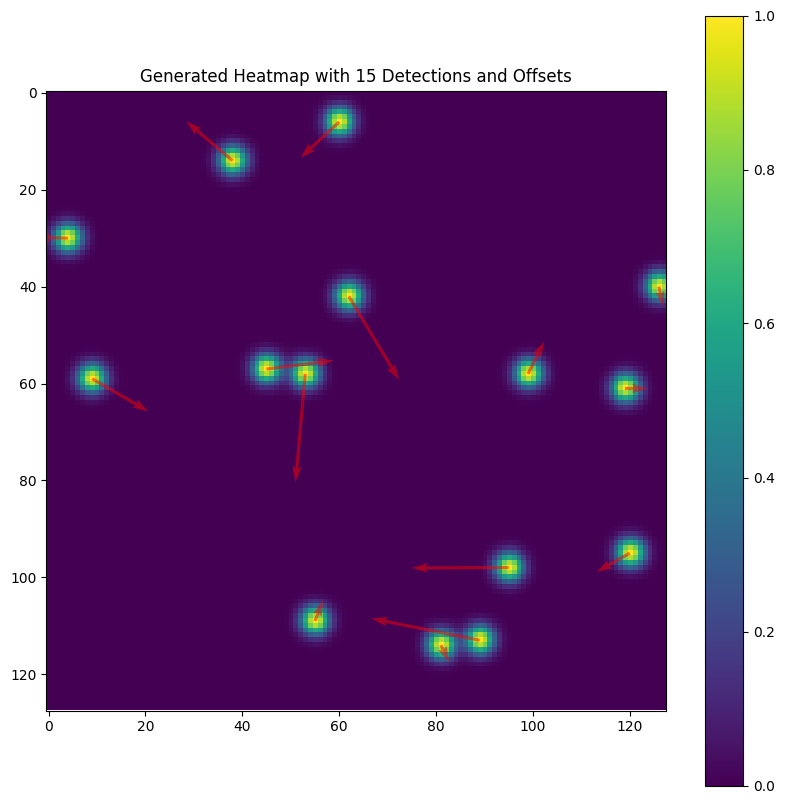

In [121]:
hm_size = (128, 128)  # Size of heatmap
num_dets = 15         # Number of detections
sigma = 2.0           # Gaussian spread
amplitude = 1.0       # Peak intensity
max_offset = 10.0     # Maximum offset magnitude

# Generate sample heatmap and offset map
sample_heatmap, sample_offsetmap, x_coords, y_coords = generate_heatmap_with_detections(
    hm_size=hm_size,
    num_detections=num_dets, 
    gaussian_sigma=sigma,
    gaussian_amplitude=amplitude,
    max_offset=max_offset
)


# Visualize the heatmap and offsets
plt.figure(figsize=(10,10))

plt.imshow(sample_heatmap[0,0].cpu())
plt.colorbar()

plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title(f'Generated Heatmap with {num_dets} Detections and Offsets')
plt.show()

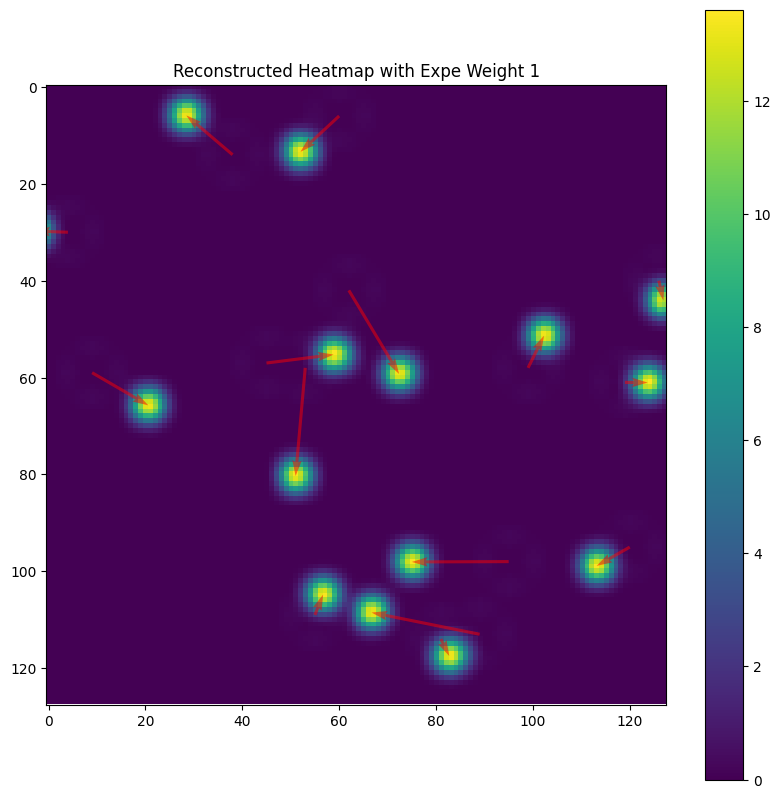

In [122]:
# Lower expe weight creates a more blurry heatmap but facilitates gradient descent

reconstructed_heatmap = reconstruct_from_motion_offset(sample_heatmap, sample_offsetmap, ksize=59, expe_weight=1)

# Visualize the reconstructed heatmap
plt.figure(figsize=(10,10))
plt.imshow(reconstructed_heatmap.squeeze().cpu())
plt.colorbar()

# Plot arrows at detection coordinates
plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title('Reconstructed Heatmap with Expe Weight 1')
plt.show()




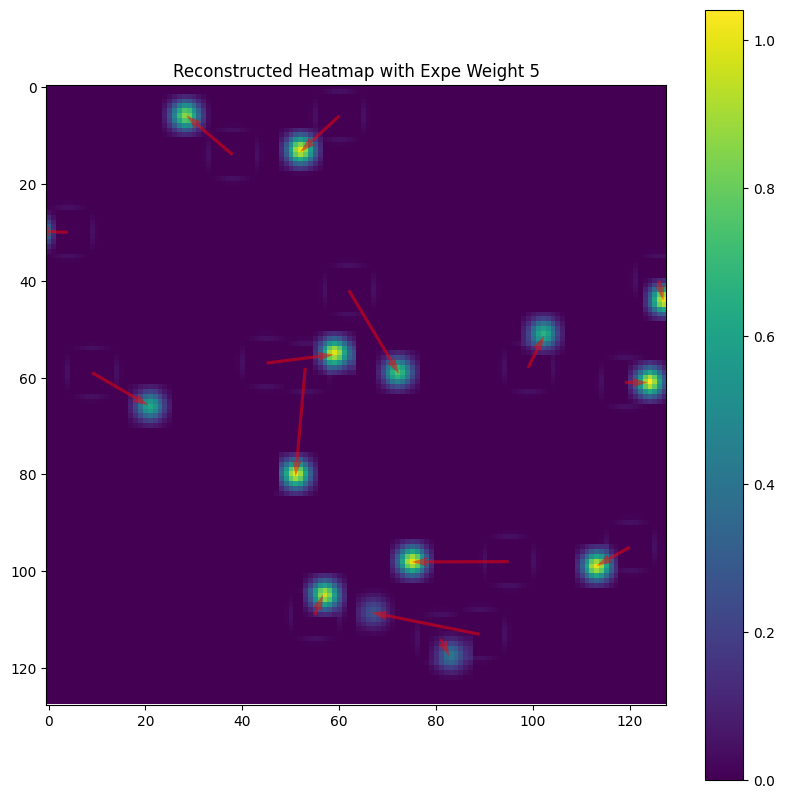

In [123]:
# Higher expe weight creates a sharper heatmap but makes gradient descent slower

reconstructed_heatmap = reconstruct_from_motion_offset(sample_heatmap, sample_offsetmap, ksize=59, expe_weight=5)

# Visualize the reconstructed heatmap
plt.figure(figsize=(10,10))
plt.imshow(reconstructed_heatmap.squeeze().cpu())
plt.colorbar()

# Plot arrows at detection coordinates
plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title('Reconstructed Heatmap with Expe Weight 5')
plt.show()